## My Framework(copy)

In [1]:
import numpy as np

In [2]:
class Module():
    def __init__(self):
        self._train = True
    
    def forward(self, input):
        raise NotImplementedError

    def backward(self,input, grad_output):
        raise NotImplementedError
    
    def parameters(self):
        'Возвращает список собственных параметров.'
        return []
    
    def grad_parameters(self):
        'Возвращает список тензоров-градиентов для своих параметров.'
        return []
    
    def train(self):
        self._train = True
    
    def eval(self):
        self._train = False

In [3]:
class Sequential(Module):
    def __init__ (self, *layers):
        super().__init__()
        self.layers = layers

    def forward(self, input):
        """
        Прогоните данные последовательно по всем слоям:
        
            y[0] = layers[0].forward(input)
            y[1] = layers[1].forward(y_0)
            ...
            output = module[n-1].forward(y[n-2])   
            
        Это должен быть просто небольшой цикл: for layer in layers...
        
        Хранить выводы ещё раз не надо: они сохраняются внутри слоев после forward.
        """

        for layer in self.layers:
            input = layer.forward(input)

        self.output = input
        return self.output

    def backward(self, input, grad_output):
        """
        Backward -- это как forward, только наоборот. (с)
        
        Предназначение backward:
        1. посчитать посчитать градиенты для собственных параметров
        2. передать градиент относительно своего входа
        
        О своих параметрах модули сами позаботятся. Нам же нужно позаботиться о передачи градиента.
         
            g[n-1] = layers[n-1].backward(y[n-2], grad_output)
            g[n-2] = layers[n-2].backward(y[n-3], g[n-1])
            ...
            g[1] = layers[1].backward(y[0], g[2])   
            grad_input = layers[0].backward(input, g[1])
        
        Тут цикл будет уже чуть посложнее.
        """
        
        for i in range(len(self.layers)-1, 0, -1):
            grad_output = self.layers[i].backward(self.layers[i-1].output, grad_output)
        
        grad_input = self.layers[0].backward(input, grad_output)
        
        return grad_input
      
    def parameters(self):
        'Можно просто сконкатенировать все параметры в один список.'
        res = []
        for l in self.layers:
            res += l.parameters()
        return res
    
    def grad_parameters(self):
        'Можно просто сконкатенировать все градиенты в один список.'
        res = []
        for l in self.layers:
            res += l.grad_parameters()
        return res
    
    def train(self):
        for layer in self.layers:
            layer.train()
    
    def eval(self):
        for layer in self.layers:
            layer.eval()

In [4]:
class Linear(Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        
        # Xavier initialization: инциализируем так,
        # что если на вход идет N(0, 1)
        # то и на выходе должно идти N(0, 1)
        stdv = 1./np.sqrt(dim_in)
        self.W = np.random.uniform(-stdv, stdv, size=(dim_in, dim_out))
        self.b = np.random.uniform(-stdv, stdv, size=dim_out)

        self.grad_W = None
        self.grad_b = None
        
    def forward(self, input):
        self.output = np.dot(input, self.W) + self.b
        return self.output
    
    def backward(self, input, grad_output):
        self.grad_b = np.mean(grad_output, axis=0)
        
        #     in_dim x batch_size
        self.grad_W = np.dot(input.T, grad_output)
        #                 batch_size x out_dim
        
        grad_input = np.dot(grad_output, self.W.T)
        
        return grad_input
    
    def parameters(self):
        return [self.W, self.b]
    
    def grad_parameters(self):
        return [self.grad_W, self.grad_b]

In [5]:
class ReLU(Module):
    def __init__(self):
         super().__init__()
    
    def forward(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def backward(self, input, grad_output):
        grad_input = np.multiply(grad_output, input > 0)
        return grad_input

In [6]:
class LeakyReLU(Module):
    def __init__(self, slope=0.03):
        super().__init__()
            
        self.slope = slope
        
    def forward(self, input):
        self.output = self.slope*input + (1 - self.slope) * np.maximum(input, 0)
        return self.output
    
    def backward(self, input, grad_output):
        grad_input = np.multiply(grad_output, input > 0) + np.multiply(grad_output * self.slope, input <= 0)
        return grad_input

In [7]:
class Sigmoid(Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output
    
    def backward(self, input, grad_output):
        # grad_input = grad_output * (1 - grad_output)
        grad_input = np.multiply(input * (1 - input), grad_output)
        return grad_input

In [8]:
class SoftMax(Module):
    def __init__(self):
         super().__init__()
    
    def forward(self, input):
        # важная деталь: если входы большие,
        # то экспоненты будут ещё больше
        input = np.subtract(input, input.max(axis=1, keepdims=True))
        exps = np.exp(input)
        self.output = np.true_divide(exps, np.sum(exps, axis=1)[:, None])
        return self.output


    def backward(self, input, grad_output):
        # grad_input = []
        # for i in range(input.shape[0]):
        #     s = input[i,:].reshape(-1, 1)
        #     j = np.diagflat(s) - np.dot(s, s.T)
        #
        #     grad_input.append((np.dot(j, grad_output[i,:].reshape(-1, 1))).reshape(input.shape[1], ))
        #
        # grad_input = np.array(grad_input) * (-1)

        batch_size = input.shape[0]
        s = self.output
        grad_local = -s[..., None] * s[:, None, :]
        iy, ix = np.diag_indices_from(grad_local[0])
        grad_local[:, iy, ix] = s * (1 - s)
        
        for i in range(grad_local.shape[0]):
            grad_local[i] = grad_local[i] * grad_output[i]
    
        grad_input = np.sum(grad_local, 2).reshape(batch_size, -1)
        grad_input = grad_input
        return grad_input

In [9]:
import torch
import torch.nn as nn
my_sm = SoftMax()
torch_sm = nn.Softmax()

In [10]:
my_data = np.random.rand(10, 4) * 10
torch_data = torch.tensor(my_data, requires_grad=True)
print(my_data)
print(torch_data)

[[7.99857425 4.14272636 1.57760739 9.28396214]
 [4.11652221 9.22542542 3.13429573 6.25558352]
 [3.07001547 9.65283887 9.97628568 6.4953895 ]
 [7.85529626 3.26301236 1.85977488 5.98119867]
 [5.20033705 2.87625926 6.67365089 6.671797  ]
 [4.52938588 2.70039111 1.65812207 4.50868548]
 [7.08790876 2.22121481 7.28401382 8.75943574]
 [8.79884045 9.68650432 5.04444082 1.98886208]
 [0.04530658 4.20360295 5.86464287 2.33034315]
 [7.94732027 8.0458791  0.30371116 0.17395883]]
tensor([[7.9986, 4.1427, 1.5776, 9.2840],
        [4.1165, 9.2254, 3.1343, 6.2556],
        [3.0700, 9.6528, 9.9763, 6.4954],
        [7.8553, 3.2630, 1.8598, 5.9812],
        [5.2003, 2.8763, 6.6737, 6.6718],
        [4.5294, 2.7004, 1.6581, 4.5087],
        [7.0879, 2.2212, 7.2840, 8.7594],
        [8.7988, 9.6865, 5.0444, 1.9889],
        [0.0453, 4.2036, 5.8646, 2.3303],
        [7.9473, 8.0459, 0.3037, 0.1740]], dtype=torch.float64,
       requires_grad=True)


In [11]:
torch_ans = torch_sm(torch_data)
torch_ans

<ipython-input-11-1f94c3ae078b>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch_ans = torch_sm(torch_data)


tensor([[2.1557e-01, 4.5605e-03, 3.5075e-04, 7.7952e-01],
        [5.7027e-03, 9.4374e-01, 2.1355e-03, 4.8424e-02],
        [5.7051e-04, 4.1224e-01, 5.6966e-01, 1.7534e-02],
        [8.5755e-01, 8.6867e-03, 2.1352e-03, 1.3163e-01],
        [1.0186e-01, 9.9697e-03, 4.4450e-01, 4.4367e-01],
        [4.5523e-01, 7.3098e-02, 2.5778e-02, 4.4590e-01],
        [1.3254e-01, 1.0204e-03, 1.6126e-01, 7.0517e-01],
        [2.8952e-01, 7.0338e-01, 6.7790e-03, 3.1926e-04],
        [2.4299e-03, 1.5542e-01, 8.1827e-01, 2.3876e-02],
        [4.7518e-01, 5.2440e-01, 2.2766e-04, 1.9995e-04]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward>)

In [12]:
t = torch.sum(torch_ans)
t

tensor(10., dtype=torch.float64, grad_fn=<SumBackward0>)

In [13]:
t.grad_fn

In [14]:
t.backward()

In [15]:
t.grad

<ipython-input-15-a758b9e683bd>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  t.grad


In [16]:
np.random.binomial(1, 0.9, size=[10]).shape

(10,)

In [17]:
class Dropout(Module):
    def __init__(self, drop_probability=0.5):
        super().__init__()

        self.output = None
        self.proba_zero = drop_probability
        self.proba_one = 1 - drop_probability

        self.mask = None

    def forward(self, input):
        if self._train:
            self.mask = np.repeat(np.random.binomial(1, p=self.proba_one,
                                                     size=[input.shape[0], 1]), input.shape[1], axis=1)
            self.output = input * self.mask
        else:
            self.output = input * self.proba_one
        return self.output
    
    def backward(self, input, grad_output):
        if self._train:
            grad_input = self.mask * grad_output * (1 / self.proba_one)
        else:
            grad_input = None
        return grad_input

In [18]:
class BatchNorm(Module):
    def __init__(self, gamma, momentum=1):
        super().__init__()
        self.gamma = gamma
        self.mu = 0
        self.sigma = 1
        self.bias = np.random.uniform(low=-1, high=1)
        self.eps = 1e-8
        self.momentum = momentum
    
    def forward(self, input):
        if self._train:
            new_mu = np.mean(input, axis=0)
            new_sigma = np.var(input, axis=0)

            self.input_norm = (input - new_mu) / np.sqrt(new_sigma + self.eps)
            self.output = self.gamma * self.input_norm + self.bias

            self.mu = (1 - self.momentum) * self.mu + self.momentum * new_mu
            self.sigma = (1 - self.momentum) * self.sigma + self.momentum * new_sigma
        else:
            input_norm = (input - self.mu) / np.sqrt(self.sigma + self.eps)
            self.output = self.gamma * input_norm + self.bias

        return self.output
    
    def backward(self, input, grad_output):
        if self._train:
            self.grad_bias = np.sum(grad_output, axis=0)
            self.grad_gamma = np.sum(grad_output*self.input_norm, axis=0)

            m = input.shape[0]
            t = 1./np.sqrt(self.sigma + self.eps)

            grad_input = (self.gamma * t / m) * (m * grad_output - np.sum(grad_output, axis=0) 
            - t**2 * (input - self.mu) * np.sum(grad_output*(grad_output - self.mu), axis=0))
        else:
            grad_input = None
        return grad_input

    def parameters(self):
        return [self.bias, self.gamma]

    def grad_parameters(self):
        return [self.grad_bias, self.grad_gamma]

In [19]:
class Criterion:
    def forward(self, input, target):
        raise NotImplementedError

    def backward(self, input, target):
        raise NotImplementedError

In [20]:
class MSE(Criterion):
    def forward(self, input, target):
        batch_size = input.shape[0]
        self.output = np.sum(np.power(input - target, 2)) / batch_size
        return self.output

    def backward(self, input, target):
        grad_input = (input - target) * 2 / input.shape[0]
        return grad_input

In [21]:
class CrossEntropy(Criterion):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        # чтобы нигде не было взятий логарифма от нуля:
        eps = 1e-3
        input_clamp = np.clip(input, eps, 1 - eps)

        self.output = np.mean(np.sum(target * np.log(input_clamp), axis=1), axis=None)
        return self.output

    def backward(self, input, target):
        eps = 1e-3
        input_clamp = np.clip(input, eps, 1 - eps)

        grad_input = input_clamp - target
        return grad_input

In [22]:
class Optimizer:
    def __init__(self):
        pass

    def step(self, params, gradients):
        pass

In [23]:
class SGD(Optimizer):
    def __init__(self, learning_rate_init=1e-3):
        super().__init__()
        self.learning_rate = learning_rate_init

    def step(self, params, gradients):
        for weights, gradient in zip(params, gradients):
            weights -= self.learning_rate * gradient

In [24]:
class Adam(Optimizer):
    def __init__(self, b1=0.9, b2=0.999, epsilon=1e-5, learning_rate_init=1e-3):
        super().__init__()
        self.num_optimizers = None
        self.learning_rate = learning_rate_init
        self.b1 = b1
        self.b2 = b2
        self.epsilon = epsilon
        self.total_calls = 1

        self.m = None
        self.v = None

    def step(self, params, gradients):
        it = 0
        if self.m is None:
            self.m = [0] * len(params)
            self.v = [0] * len(params)

        for weights, gradient in zip(params, gradients):
            self.m[it] = self.b1 * self.m[it] + (1 - self.b1) * gradient
            self.v[it] = self.b2 * self.v[it] + (1 - self.b2) * gradient**2

            m_hat = self.m[it] / (1 - np.power(self.b1, self.total_calls))
            v_hat = self.v[it] / (1 - np.power(self.b2, self.total_calls))

            weights -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

            it += 1

        self.total_calls += 1

# Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения
* [Xavier, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

<img width='800px' src='https://cdn-images-1.medium.com/max/1600/1*q1M7LGiDTirwU-4LcFq7_Q.png'>

Иногда сети пишут на чистом C++, причём код для обучения и инференса (реального прогона в продакшне) — отдельно. Так делают, когда нужен очень быстрый отклик и высокая производительность, но это очень трудоемко.

Большинство людей не усложняют себе жизнь и просто используют фреймворки — с ними можно просто почти декларативно описать, какие операции хотите сделать с данными, а он потом сам построит сеть и подгонит её под данные.

Ваше задание — реализовать свой небольшой фреймворк глубокого обучения на чистом `numpy`. Основное время у вас должно уйти на вывод формул для градиентов, анализ поведения самых часто используемых слоев в современных нейросетях и прочий матан. Хотя бы один раз в жизни это надо сделать, а уже потом пользоваться готовыми абстракциями.

Предполагаемый порядок выполнения:
* Поймите на высоком уровне, как работает алгоритм backpropagation
* Изучите пример с логиситической регрессией, чтобы понять, что от вас в итоге хотят
* Изучите код `Module`
* `Sequential`
* `Linear`
* `SoftMax`
* `CrossEntropy`
* Протестируйте их на логситической регрессии
* Напишите код для решения MNIST
* Дописывайте остальные слои, пока не получите на нём 97%

Оценивание (суммарно до 20 баллов):
* 5 баллов -- что-то хоть как-то обучается, MNIST на валидации >90%
* 2 балла -- MNIST на 95%, дальше по одному баллу за 96%, 97% и 98%. Это будет сделать намного сложнее, чем через PyTorch, потому что вам всё нужно писать самим: более сложные оптимизаторы, learning rate decay, думать про численную стабильность и т. д.
* По 2 балла за слои: LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax

Советы:
* Чтобы лучше понять, что должно в итоге получиться, изучите «игрушечный пример» и вообще эту тетрадку, а потом начните читать `hw_framework.py`, где будет более техничное описание.
* Для дебага проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу. Ещё можете проверить, что на одинаковых данных они дают то же, что их эквиваленты из PyTorch (можно после каждого нового слоя добавить юнит тест через `assert`).
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy.
* Ограничение на срок сдачи большое — до конца всего курса, но рекомендуется закончить примерно за месяц. Дописывайте его постепенно, разбираясь, как работает каждая функция активации.
* Обсуждайте математику и общую архитектуру фреймворка, но не шарьте друг другу код — так не интересно.

In [25]:
import numpy as np
import matplotlib.pyplot as plt

---

Откройте в Jupyter две тетрадки — эту и `hw_framework.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать.

Архитектура фреймворка вдохновлена PyTorch. Как всегда, если придумаете какой-то более клёвый дизайн — можете использовать его.

In [26]:
#%run hw_framework.ipynb

Мы будем использовать самый простой вариант градиентного спуска: просто пройдемся по всем параметрам и сделаем шаги в сторону уменьшения посчитанного заранее градиента.

Есть [более продвинутые методы](http://ruder.io/optimizing-gradient-descent/), но пока что мы их использовать не будем.

In [27]:
def grad_clipping(gradients, max_clip=1):
    # ans = []
    for gradient in gradients:
        gradient.clip(0, 0)
    # return ans

Cоздадим обертку вокруг нашего датасета (просто numpy-евские массивы), которую будем потом использовать, чтобы итерироваться по нему.

In [28]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. В них ничего менять не надо — они нужны, чтобы отдебажить ваши слои в `hw_framework`.

# Линейная регрессия

In [29]:
n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = (np.dot(X, true_w).reshape(n) + np.random.randn(n)/5).reshape(n, 1)

print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n), 2)))

best_possible_mse: 9.313211477050203


### Модель

In [42]:
epochs = 20
batch_size = 1000
learning_rate = 1e-2

In [43]:
def block(input_size, output_size):
    return Sequential(
        Linear(input_size, output_size),
        LeakyReLU(),
        #Dropout(drop_probability=0.2)
    )

In [44]:
model = Sequential(
    block(10, 700),
    block(700, 500),
    block(500, 300),
    block(300, 100),
    block(100, 30),
    block(30, 10),
    Linear(10, 1)
)

criterion = MSE()

In [45]:
# model = Sequential(
#     Linear(10, 1)
# )

In [46]:
optimizer = Adam(learning_rate_init=learning_rate)

Можете тут потом тестировать остальные свои слои, когда их напишите.

### Обучение

In [47]:
def criterion_xy_loss(model, X, y_true):
    model.eval()
    y_pred = model.forward(X)
    return criterion.forward(y_pred, y_true)

0 4.5629999323227715
1 3.1102229685414122
2 3.9182035078666035
3 1.643893148892721
4 0.8098473371093219
5 0.5791393843439507
6 0.16776535536660744
7 0.6220347237732947
8 0.3337940741840468
9 0.45834185245992776
10 0.5439261404196818
11 0.24304324453990195
12 0.21367564217746488
13 0.2673230910862635
14 0.1905737204567452
15 0.09878200559210308
16 0.21929910989096305
17 0.1599732505336313
18 0.09565636435601235
19 0.13723779630239147
20 0.12161803699777377
21 0.10409196803422738
22 0.059222996929804574
23 0.10703860860718391
24 0.09299835675927662
25 0.04800644134528976
26 0.07472412836589455
27 0.0725049456473668
28 0.06483270914708043
29 0.05359749062963947
30 0.057464943008096785
31 0.07066714928019226
32 0.043056752343006995
33 0.047319907525174044
34 0.0580239163782078
35 0.043574510837530514
36 0.04389922434908
37 0.04347028664295915
38 0.047918920643957946
39 0.04138479081917175
40 0.03654604347918513
41 0.04649727328740098
42 0.03827555381659699
43 0.03657519846516252
44 0.04010

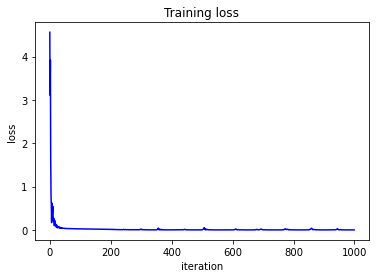

In [48]:
history = []

for i in range(1000):
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        model.train()

        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        
        #print(y_pred, y_true)
        #print('SUM OF SQUARES:', np.mean(np.power(y_pred-y_true, 2)))
    
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        grad_clipping(model.grad_parameters(), max_clip=0)
        optimizer.step(model.parameters(),
                       model.grad_parameters())


        history.append(criterion_xy_loss(model, x, y_true))
    
    print(i, history[-1])

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history[:], 'b')
plt.show()

In [49]:
loss = criterion.forward(y_pred, y_true)
loss

0.0009446062234868588

# Логистическая регрессия

Этот пример нужнен для теситрования классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

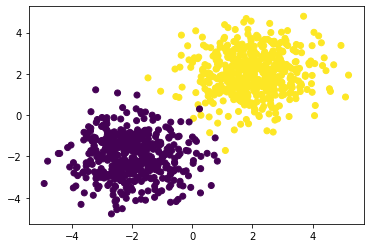

In [50]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([Y, 1-Y])

plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.show()

Обратите внимание на `y`. Он в формате one-hot: у каждого вектора все нули, кроме одной единицы.

Выходные данные в таком формате упростят написание `CrossEntropy`.

### Модель

Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой, софтмакс, и максимизируем правдоподобие.

In [52]:
def block(input_size, output_size):
    return Sequential(
        Linear(input_size, output_size),
        ReLU(),
        Dropout(drop_probability=0.5)
    )

In [54]:
model = Sequential(
    block(2, 100),
    block(100, 150),
    block(150, 100),
    block(100, 50),
    block(50, 30),
    block(30, 10),
    block(10, 5),

    Linear(5, 2),
    SoftMax()
)

criterion = CrossEntropy()

In [55]:
model = Sequential(
    Linear(2, 2),
    SoftMax()
)
criterion = CrossEntropy()

In [56]:
optimizer = Adam(learning_rate_init=learning_rate)

### Обучение

In [57]:
epochs = 100
batch_size = 20
learning_rate = 1e-2

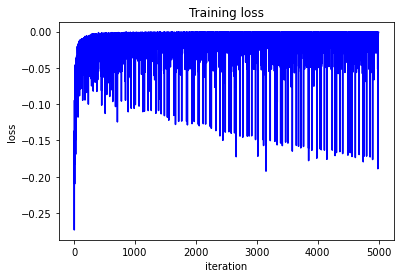

In [59]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        model.train()

        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)

        #print(y_pred, y_true)
        #print('SUM OF SQUARES:', np.mean(np.power(y_pred-y_true, 2)))

        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)

        # обновляем веса
        grad_clipping(model.grad_parameters(), max_clip=0)
        optimizer.step(model.parameters(),
                       model.grad_parameters())


        history.append(criterion_xy_loss(model, x, y_true))

plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [63]:
history[-1]

-0.0010796955972120898

In [60]:
def accuracy(y_true, y_pred):
    y_max = np.argmax(y_true, axis=1)
    y_pr = np.argmax(y_pred, axis=1)
    return np.sum(y_max == y_pr) / y_true.shape[0]

In [61]:
model.forward(X)

array([[9.99999322e-01, 6.77608560e-07],
       [1.00000000e+00, 3.59338193e-11],
       [1.00000000e+00, 9.82107530e-11],
       ...,
       [1.60408439e-08, 9.99999984e-01],
       [1.90909474e-02, 9.80909053e-01],
       [1.01293213e-07, 9.99999899e-01]])

In [62]:
print(accuracy(model.forward(X), Y))

0.997


Мы тут пропустили много важных деталей: валидация, подсчет точности (кроссэнтропия не очень информативна), регуляризация. Вам всё это нужно будет реализовать потом самим.

# Теперь сами

In [67]:
import os
from sklearn.datasets import fetch_openml
# эти библиотеки нужны только для того, чтобы скачать MNIST

if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_openml("mnist_784")
    # очень важно его отнормировать -- см. Linear в hw_framework
    X = mnist.data / 255.0
    y = mnist.target
    np.savez('mnist.npz', X=X, y=y)

Переведите лейблы в one-hot.

In [68]:
import pandas as pd
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [69]:
y_ = pd.get_dummies(y, columns=['y'])
y_

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
69995,0,0,1,0,0,0,0,0,0,0
69996,0,0,0,1,0,0,0,0,0,0
69997,0,0,0,0,1,0,0,0,0,0
69998,0,0,0,0,0,1,0,0,0,0


Разделите датасет на train и validation.

In [70]:
X_ = X.to_numpy()
y_ = y_.to_numpy()

In [71]:
mask = np.random.permutation(np.arange(y.shape[0]))

X_ = X_[mask]
y_ = y_[mask]

train_shape = 50000
X_train, X_val = X_[:train_shape , :], X_[train_shape: , :]
y_train, y_val = y_[:train_shape, :], y_[train_shape: , :]

## Fit

In [78]:
def accuracy_Xy(model, X, y_true):
    model.eval()
    y_pred = model.forward(X)
    return accuracy(y_true, y_pred)

In [79]:
def block(input_size, output_size):
    return Sequential(
        Linear(input_size, output_size),
        LeakyReLU(),
        Dropout(drop_probability=0.5),
    )

In [80]:
def seq_by_sizes(sizes):
    ans = []
    for i in range(len(sizes) - 2):
        for j in block(sizes[i - 1], sizes[i]):
            ans.append(j)

    ans.append(Linear(sizes[-2], sizes[-1]))
    ans.append(SoftMax())

    return Sequential(ans)

In [81]:
model = Sequential(
    block(784, 700),
    block(700, 600),
    block(600, 500),
    block(500, 400),
    block(400, 300),
    block(300, 200),
    block(200, 100),
    block(100, 50),
    block(50, 25),

    Linear(25, 10),
    SoftMax()
)
#
# sizes = [784]
# for i in range(750, 49):
#     sizes.append(i)
# sizes += [45, 40, 35, 30, 25, 20, 15, 10]
# model = seq_by_sizes(sizes)

criterion = CrossEntropy()
optimizer = Adam(learning_rate_init=1e-2)

In [82]:
epochs = 50
batch_size = 500

In [ ]:
history = []

for i in range(epochs):
    for x, y_true in loader(X_train, y_train, batch_size):
        model.train()

        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)

        #print(y_pred, y_true)
        #print('SUM OF SQUARES:', np.mean(np.power(y_pred-y_true, 2)))

        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)

        # обновляем веса
        grad_clipping(model.grad_parameters(), max_clip=0.4)
        optimizer.step(model.parameters(),
                       model.grad_parameters())

        history.append(criterion_xy_loss(model, x, y_true))
    print('acc', accuracy_Xy(model, X_train, y_train))
    print('los', criterion_xy_loss(model, X_train, y_train))
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

acc 0.08594
los -5.220881120321846
acc 0.13434
los -5.720958602753417
acc 0.13274
los -5.87242598179923
acc 0.10448
los -6.184464990873898
acc 0.10252
los -6.199674779075089
acc 0.10252
los -6.199674779075089
acc 0.10252
los -6.199674779075089
acc 0.08626
los -6.311926634399593


In [245]:
print(np.argmax(model.forward(X_train), axis=1)[:30])
print(np.argmax(y_train, axis=1)[:30])
# y_pr = np.argmax(y_pred, axis=1)

[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
[0 8 2 7 8 1 7 6 7 6 2 6 7 4 5 1 2 1 6 8 9 9 1 0 6 4 9 6 1 5]


In [ ]:
print(y_train.sum(axis=0))

[4905 5663 5018 5073 4854 4525 4902 5241 4864 4955]


In [ ]:
model.forward(X_val)[:10,:]

array([[4.78000131e-07, 4.16088226e-07, 9.99995806e-01, 3.51352613e-07,
        4.69756537e-07, 4.14684528e-07, 2.92854386e-07, 1.12989179e-06,
        2.74661389e-07, 3.66477779e-07],
       [4.29136165e-07, 2.83218011e-07, 9.99997705e-01, 2.64465470e-07,
        2.12119559e-07, 2.40787963e-07, 2.08480996e-07, 2.28210768e-07,
        2.31813954e-07, 1.96684773e-07],
       [1.36218705e-09, 7.01727824e-10, 9.99999994e-01, 5.22055469e-10,
        5.99181478e-10, 5.00138649e-10, 4.67169038e-10, 9.71930170e-10,
        5.67837853e-10, 5.62787852e-10],
       [3.11876821e-07, 3.71646772e-07, 9.99997055e-01, 5.33213798e-07,
        3.24334843e-07, 2.82180338e-07, 3.42621047e-07, 2.53407853e-07,
        2.25143956e-07, 3.00355679e-07],
       [8.86389354e-08, 5.98093755e-07, 9.99998508e-01, 1.35276493e-07,
        1.41537002e-07, 9.73468642e-08, 9.73873657e-08, 1.42262344e-07,
        1.06191079e-07, 8.50157887e-08],
       [3.01697129e-07, 3.13360829e-07, 9.99997693e-01, 2.15750479e-07,
   

Теперь напишите модель и train loop. Можете начать с адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* поиграйтесь с архитектурами;
* поиграйтесь с learning rate и batch_size;
* сделайте learning rate decay;
* сделайте data augmentation.

Have fun. Дедлайн — не две недели, а до конца курса.

In [ ]:
# ...

In [ ]:
# ...